In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
from PIL import Image
from PIL import ImageDraw
from skimage.io import imread
import matplotlib.patches as patches
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import albumentations as A
import albumentations.pytorch
from tqdm.notebook import tqdm
from collections import Counter
import datetime
import copy

%matplotlib inline

In [ ]:
!pip install ipympl

In [ ]:
%matplotlib widget
import ipywidgets as widgets
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
output.disable_custom_widget_manager()

In [ ]:
! pip install albumentations==0.4.6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/unique_Fields.zip

In [ ]:
!cp /content/drive/MyDrive/annot_3_30.json /content

# auxiliary 

In [ ]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [ ]:
def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()


In [ ]:
def iou_width_height(boxes1, boxes2):
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [ ]:
def get_val_boxes(val_loader, model, scaled_anchors, anchors, iou_thresh, thresh, device= torch.device("cuda:0")):
  model.eval()
  all_pred_boxes = []
  all_true_boxes = []
  train_idx = 0
  for batch_idx, (x, labels, im_name, im_id) in enumerate(val_loader):
      x = x.to(device)
      y0 = labels[0].to(device)
      with torch.no_grad():
        pred = model(x)

      batch_size = x.shape[0]
      bboxes = [[] for _ in range(batch_size)]
      for i in [0]:
        S = pred[i].shape[2]
        anchor = torch.tensor([*anchors[0]]).to(device) * S
        boxes_scale_i = cells_to_bboxes(
            pred[i], anchor, S=S, is_preds=True
        )
        for idx, (box) in enumerate(boxes_scale_i):
              bboxes[idx] += box

      true_bboxes = cells_to_bboxes(
          labels[0], anchor, S=S, is_preds=False
      )

      for idx in range(batch_size):
          nms_boxes = non_max_suppression(
              bboxes[idx],
              iou_threshold=iou_thresh,
              threshold=thresh,
              box_format='midpoint',
          )

          for nms_box in nms_boxes:
              all_pred_boxes.append([train_idx] + nms_box)

          for box in true_bboxes[idx]:
              if box[1] > thresh:
                  all_true_boxes.append([train_idx] + box)

          train_idx += 1
  return all_pred_boxes, all_true_boxes

In [ ]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=1
):
    """
    Video explanation of this function:
    https://youtu.be/FppOzcDvaDI
    This function calculates mean average precision (mAP)
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions), recalls

In [ ]:
def metrics(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=1
):

    # used for numerical stability later on
    epsilon = 1e-6

    center_x = 0
    center_y = 0
    fwhm_x = 0
    fwhm_y = 0
    cnt = 0
    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]
            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                    center_x += (416 * np.abs(ground_truth_img[best_gt_idx][3] - detection[3]))
                    center_y += (416 * np.abs(ground_truth_img[best_gt_idx][4] - detection[4]))
                    fwhm_x += (416 * np.abs(ground_truth_img[best_gt_idx][5] -  detection[5]))
                    fwhm_y += (416 * np.abs(ground_truth_img[best_gt_idx][6] - detection[6]))
                    cnt += 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        recall = torch.max(recalls).item()
        f1_score = (2 * 1 * recall) / (1 + recall) 
    return (recall, f1_score) if cnt == 0 \
          else (recall, f1_score, center_x / cnt, center_y / cnt, fwhm_x / cnt, fwhm_y / cnt)

In [ ]:
def plot_image(image, pred_boxes, true_boxes):
  fig, ax = plt.subplots(1, 2, figsize=(10,10), dpi=120)
  im = (image.permute(1, 2, 0) * torch.tensor(stats['std'])[None,None,:] \
            + torch.tensor(stats['mean'])[None,None,:])[:, :, 0]
  im_s = im.shape[0]
  ax[0].imshow(im, cmap='viridis', vmin = im.mean() - im.std(), vmax = im.mean() + im.std()
          )
  ax[1].imshow(im, cmap='viridis', vmin = im.mean() - im.std(), vmax = im.mean() + im.std()
          )
  for box in pred_boxes:
    assert len(box) == 6
    class_pred = box[0]
    box = box[2:]
    upper_left_x = box[0] -1/416  - box[2] / 2
    upper_left_y = box[1] -1/416 - box[3] / 2
    rect_pred = patches.Rectangle(
        (upper_left_x * im_s, upper_left_y * im_s),
        box[2] * im_s,
        box[3] * im_s,
        linewidth=0.4,
        edgecolor='r',
        facecolor="none",
    )
    ax[0].add_patch(rect_pred)
    
  for box in true_boxes:
    assert len(box) == 6
    class_pred = box[0]
    box = box[2:]
    upper_left_x = box[0] - box[2] / 2
    upper_left_y = box[1] - box[3] / 2
    rect_true = patches.Rectangle(
        (upper_left_x * im_s, upper_left_y * im_s),
        box[2] * im_s,
        box[3] * im_s,
        linewidth=0.4,
        edgecolor='r',
        facecolor="none",
    )
    ax[1].add_patch(rect_true)


  plt.show()

In [ ]:
def couple_exmpls(loader, thresh, iou_thresh, anchors):
    model.eval()
    x, y, im_name, im_id = next(iter(loader))
    x = x.to(device)
    with torch.no_grad():
        out = model(x)
    
    batch_size = x.shape[0]
    bboxes_pred = [[] for _ in range(batch_size)]
    bboxes_true = [[] for _ in range(batch_size)]
    for i in [0]:
        S = out[i].shape[2]
        anchor = torch.tensor([*anchors[0]]).to(device) * S
        boxes_scale_i_pred = cells_to_bboxes(
            out[i], anchor, S=S, is_preds=True
        )
        for idx, (box) in enumerate(boxes_scale_i_pred):
            bboxes_pred[idx] += box

        boxes_scale_i_true= cells_to_bboxes(
            y[i], anchor, S=S, is_preds=False
        )
        for idx, (box) in enumerate(boxes_scale_i_true):
            bboxes_true[idx] += box
    
    for i in range(batch_size):
        nms_boxes_pred = non_max_suppression(
            bboxes_pred[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
        )
        nms_boxes_true= non_max_suppression(
            bboxes_true[i], iou_threshold=1, threshold=0.5, box_format="midpoint",
        )
        print(f'Pred/true boxes: {len(nms_boxes_pred)}/{len(nms_boxes_true)}\nCrop from {im_name[i]}')
        plot_image(x[i].to("cpu"), nms_boxes_pred, nms_boxes_true)

In [ ]:
def get_bias_prediction(img, thresh, iou_thresh, anchors, transform=True, x_bias=0, y_bias=0):
    model.eval()
    img = img.to(device)
    with torch.no_grad():
        out = model(img)
    
    bboxes_pred = [[]]
    for i in [0]:
        S = out[i].shape[2]
        anchor = torch.tensor([*anchors[0]]).to(device) * S
        boxes_scale_i_pred = cells_to_bboxes(
            out[i], anchor, S=S, is_preds=True
        )
        for idx, (box) in enumerate(boxes_scale_i_pred):
            bboxes_pred[idx] += box
    
    nms_boxes_pred = non_max_suppression(
        bboxes_pred[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
    )

    for i in range(len(nms_boxes_pred)):
      if transform:
          nms_boxes_pred[i][2] = nms_boxes_pred[i][2] - 1/416 + y_bias / 416
          nms_boxes_pred[i][3] = nms_boxes_pred[i][3] - 1/416 + x_bias / 416
      else:
        nms_boxes_pred[i][2] = nms_boxes_pred[i][2] - 1/416
        nms_boxes_pred[i][3] = nms_boxes_pred[i][3] - 1/416
    return nms_boxes_pred

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = np.inf

    def early_stop(self, loss):
        if loss < self.min_loss:
            self.min_loss = loss
            self.counter = 0
        elif loss > (self.min_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Dataset

In [207]:
anchors = [[(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],]
S= [104]

In [208]:
class YOLODataset(torch.utils.data.Dataset):
    def __init__(
        self,
        *,
        path = '/content/',
        anchors,
        train=True,
        seed=15,
        image_size=416,
        S=[13, 26, 52],
        C=1,
        transform=None,
    ):
        self.path = path
        self.image_size = image_size
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0]) #+ anchors[1] + anchors[2])
        self.num_anchors = 9 #self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5
        
        with open(os.path.join(self.path, "annot_3_30.json")) as f:
                annotations = np.array(json.load(f))
                bad_samples = [1, 3, 7, 18, 19, 21, 22, 25, 29, 31, 32,  34, 36, 37,  44, 48, 56, 57, 58, 59, 60,  67, 68, \
              79, 80, 87, 88, 91, 93, 94, 98, 114,  128, 132,]
                res_idx = set([x for x in range(len(annotations))]) - set(bad_samples)
                annotations = annotations[list(res_idx)]

        
        np.random.seed(seed)
        permutation = np.random.permutation(len(annotations))

        if train:
            self.annotations = annotations[permutation[:int(len(annotations) * 0.9)]].tolist()

        else:
            self.annotations = annotations[permutation[int(len(annotations) * 0.9):]].tolist()



    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image = imread(os.path.join(self.path, 'unique_Fields', ann['filename']), plugin='fits').astype('float32')[:, :, None]
        bboxes = [b[:5] for b in ann["bboxes"]]
        image_id = torch.tensor([idx])
        if self.transform is not None:
            im_b = self.transform(image=image, bboxes=bboxes)
            red_image = im_b['image']
            red_bboxes = im_b['bboxes']
            while len(red_bboxes) == 0:
              im_b = self.transform(image=image, bboxes=bboxes)
              red_image = im_b['image']
              red_bboxes = im_b['bboxes']
            pre_target = {'image': red_image, 'boxes': red_bboxes, 'img_id': image_id, 'img_name': ann['filename']}
        else:
            pre_target = {'image': image, 'boxes': bboxes, 'img_id': image_id, 'img_name': ann['filename']}

        
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
        for box in pre_target['boxes']:
            wh = torch.tensor([box[1] - box[0], box[3] - box[2]]) / self.image_size
            iou_anchors = iou_width_height(wh, self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x_min, y_min, x_max, y_max, class_label = [x / self.image_size for x in box]
            x = (x_min + x_max) / 2
            y = (y_min + y_max) / 2
            width = (x_max - x_min)
            height = (y_max - y_min)
            has_anchor = [False] * 3
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = S * x - j, S * y - i  
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )  
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1
        return pre_target['image'], tuple(targets), pre_target['img_name'], pre_target['img_id']

In [209]:
stats = {'mean': [1115.91], 'std': [300.8]}

In [210]:
train_transform = A.Compose(
    [   
        A.CenterCrop(4000, 4000),
        A.RandomCrop(416, 416),
        A.HorizontalFlip(0.5),
        A.VerticalFlip(0.5),
        A.pytorch.ToTensor(normalize=stats
                           ),
    ],
    bbox_params=dict(format='pascal_voc', min_visibility=0.4)
)
test_transform = A.Compose(
    [   
        A.CenterCrop(4000, 4000),
        A.RandomCrop(416, 416),
        A.pytorch.ToTensor(normalize=stats
                           ),
    ],
    bbox_params=dict(format='pascal_voc', min_visibility=0.4)
)


In [211]:
train_dataset = YOLODataset(
        S=S,
        anchors=anchors,
        transform=train_transform, train=True
    )
val_dataset = YOLODataset(
        S=S,
        anchors=anchors,
        transform=test_transform, train=False
    )

In [212]:
train = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

In [213]:
train_dataset.__len__()

95

In [214]:
val_dataset.__len__()

11

# Loss

In [ ]:
class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bcewll = nn.BCEWithLogitsLoss()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.sigmoid_function = nn.Sigmoid()
        self.l_nj = 1
        self.l_box = 1
        self.l_obj = 1


    def forward(self, preds, target, anchors):
        # Check where obj and nj (we ignore if target == -1)
        obj = target[..., 0] == 1  
        nj = target[..., 0] == 0 

        # no obj loss

        no_object_loss = self.bcewll(
            (preds[..., 0:1][nj]), (target[..., 0:1][nj]),
        )

        # obj loss

        anchors = anchors.reshape(1, 3, 1, 1, 2)

        box_preds = torch.cat([self.sigmoid_function(preds[..., 1:3]), torch.exp(preds[..., 3:5]) * anchors], dim=-1)
        result = intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()

        loss_obj = self.mse(self.sigmoid_function(preds[..., 0:1][obj]), result * target[..., 0:1][obj])

        # box coord

        preds[..., 1:3] = self.sigmoid_function(preds[..., 1:3])  # x,y coordinates
        target[..., 3:5] = torch.log(
            (1e-16 + target[..., 3:5] / anchors)
        )
        box_loss = self.mse(preds[..., 1:5][obj], target[..., 1:5][obj])

        # class loss

        class_loss = self.cross_entropy(
            (preds[..., 5:][obj]), (target[..., 5][obj].long()),
        )
        return (
                self.l_box * box_loss
                + self.l_obj * loss_obj
                + self.l_nj * no_object_loss
        )

# Model

In [ ]:
config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 1),
    ["B", 2],
    (512, 3, 2),
    ["B", 4],
    (1024, 3, 1),
    ["B", 4],
    (1024, 3, 1),
    ["B", 2],  # To this point is Darknet-53
    (256, 1, 1),
    (64, 1, 1),
    "S",
]



class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)

        return x


class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2 * in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1
            ),
        )
        self.num_classes = num_classes

    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )

In [ ]:
class EditedYOLO(nn.Module):
    def __init__(self, in_channels=1, num_classes=1):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []  # for each scale
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes),
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3

        return layers


In [ ]:
model = EditedYOLO()

In [ ]:
from torchsummary import summary
summary(model.cuda(), (1, 416, 416), batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 416, 416]             288
       BatchNorm2d-2         [-1, 32, 416, 416]              64
         LeakyReLU-3         [-1, 32, 416, 416]               0
          CNNBlock-4         [-1, 32, 416, 416]               0
            Conv2d-5         [-1, 64, 208, 208]          18,432
       BatchNorm2d-6         [-1, 64, 208, 208]             128
         LeakyReLU-7         [-1, 64, 208, 208]               0
          CNNBlock-8         [-1, 64, 208, 208]               0
            Conv2d-9         [-1, 32, 208, 208]           2,048
      BatchNorm2d-10         [-1, 32, 208, 208]              64
        LeakyReLU-11         [-1, 32, 208, 208]               0
         CNNBlock-12         [-1, 32, 208, 208]               0
           Conv2d-13         [-1, 64, 208, 208]          18,432
      BatchNorm2d-14         [-1, 64, 2

# train

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors, device= torch.device("cuda:0")):
    loop = tqdm(train_loader, leave=True)
    losses = []
    model.train()
    for batch_idx, (x, y, im_name, im_id) in enumerate(loop):
        x = x.to(device)
        batch_size = x.shape[0]
        y0 = y[0].to(device)

        out = model(x)
        loss = (
            loss_fn(out[0], y0, scaled_anchors)
        )

        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)
    return mean_loss

In [ ]:
def val_fn(val_loader, model,  loss_fn, scaled_anchors, device= torch.device("cuda:0")):
    loop = tqdm(val_loader, leave=True)
    losses = []
    all_pred_boxes = []
    all_true_boxes = []
    train_idx = 0
    model.eval()
    for batch_idx, (x, labels, im_name, im_id) in enumerate(loop):
        x = x.to(device)
        y0 = labels[0].to(device)
        with torch.no_grad():
          pred = model(x)
          loss = (loss_fn(pred[0], y0, scaled_anchors.to(device)))

        losses.append(loss.item())
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)
    return mean_loss

In [ ]:
def get_val_boxes(val_loader, model, scaled_anchors, anchors, iou_thresh, thresh, device= torch.device("cuda:0")):
  model.eval()
  all_pred_boxes = []
  all_true_boxes = []
  train_idx = 0
  for batch_idx, (x, labels, im_name, im_id) in enumerate(val_loader):
      x = x.to(device)
      y0 = labels[0].to(device)
      with torch.no_grad():
        pred = model(x)

      batch_size = x.shape[0]
      bboxes = [[] for _ in range(batch_size)]
      for i in [0]:
        S = pred[i].shape[2]
        anchor = torch.tensor([*anchors[0]]).to(device) * S
        boxes_scale_i = cells_to_bboxes(
            pred[i], anchor, S=S, is_preds=True
        )
        for idx, (box) in enumerate(boxes_scale_i):
              bboxes[idx] += box

      true_bboxes = cells_to_bboxes(
          labels[0], anchor, S=S, is_preds=False
      )

      for idx in range(batch_size):
          nms_boxes = non_max_suppression(
              bboxes[idx],
              iou_threshold=iou_thresh,
              threshold=thresh,
              box_format='midpoint',
          )

          for nms_box in nms_boxes:
              all_pred_boxes.append([train_idx] + nms_box)

          for box in true_bboxes[idx]:
              if box[1] > thresh:
                  all_true_boxes.append([train_idx] + box)

          train_idx += 1
  return all_pred_boxes, all_true_boxes

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()

54

In [ ]:
def save_state_model():
  state = {'epoch': epoch, 'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict(),}
  torch.save(state, f'/content/drive/MyDrive/model_state/model_checkpoint.pt')

In [ ]:
def load_checkpoint(model, optimizer, filename):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

In [ ]:
lr=1e-4
N_epochs = 200
scaled_anchors = (torch.tensor(anchors) 
    * torch.tensor(S))[0, :, :]
scaled_anchors = scaled_anchors.to(device)

model = EditedYOLO().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = YoloLoss()
scaler = torch.cuda.amp.GradScaler()
early_stopper = EarlyStopper(patience=10)

tr_epochs_loss = []
val_epochs_loss = []
f_1 = []
rec = []
prev_loss = 1e+10
for epoch in range(1, N_epochs + 1):
  print(f'Train: {epoch}')
  tr_loss = train_fn(train, model, optimizer, loss_fn, scaler, scaled_anchors, device=device)
  tr_epochs_loss.append(tr_loss)
  print(f'Val: {epoch}')
  val_loss = val_fn(test, model, loss_fn, scaled_anchors, device= device)
  val_epochs_loss.append(val_loss)

  save_state_model()

  if early_stopper.early_stop(tr_loss):
        print(f"Early stoping on {epoch} epoch ")         
        break

  if epoch >= 10:
    pred_b, true_b = get_val_boxes(test, model, scaled_anchors, anchors, 0.45,  0.6, device=device)
    met = metrics(pred_b, true_b)
    rec.append(met[0])
    f_1.append(met[1])

Train: 1


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 1


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 2


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 2


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 3


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 3


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 4


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 4


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 5


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 5


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 6


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 6


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 7


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 7


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 8


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 8


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 9


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 9


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 10


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 10


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 11


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 11


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 12


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 12


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 13


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 13


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 14


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 14


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 15


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 15


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 16


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 16


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 17


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 17


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 18


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 18


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 19


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 19


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 20


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 20


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 21


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 21


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 22


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 22


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 23


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 23


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 24


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 24


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 25


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 25


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 26


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 26


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 27


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 27


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 28


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 28


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 29


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 29


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 30


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 30


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 31


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 31


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 32


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 32


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 33


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 33


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 34


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 34


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 35


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 35


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 36


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 36


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 37


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 37


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 38


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 38


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 39


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 39


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 40


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 40


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 41


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 41


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 42


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 42


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 43


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 43


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 44


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 44


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 45


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 45


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 46


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 46


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 47


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 47


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 48


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 48


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 49


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 49


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 50


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 50


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 51


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 51


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 52


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 52


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 53


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 53


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 54


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 54


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 55


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 55


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 56


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 56


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 57


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 57


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 58


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 58


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 59


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 59


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 60


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 60


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 61


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 61


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 62


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 62


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 63


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 63


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 64


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 64


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 65


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 65


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 66


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 66


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 67


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 67


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 68


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 68


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 69


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 69


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 70


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 70


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 71


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 71


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 72


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 72


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 73


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 73


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 74


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 74


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 75


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 75


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 76


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 76


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 77


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 77


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 78


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 78


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 79


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 79


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 80


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 80


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 81


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 81


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 82


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 82


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 83


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 83


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 84


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 84


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 85


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 85


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 86


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 86


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 87


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 87


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 88


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 88


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 89


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 89


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 90


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 90


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 91


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 91


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 92


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 92


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 93


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 93


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 94


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 94


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 95


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 95


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 96


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 96


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 97


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 97


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 98


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 98


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 99


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 99


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 100


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 100


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 101


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 101


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 102


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 102


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 103


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 103


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 104


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 104


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 105


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 105


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 106


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 106


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 107


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 107


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 108


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 108


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 109


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 109


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 110


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 110


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 111


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 111


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 112


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 112


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 113


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 113


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 114


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 114


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 115


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 115


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 116


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 116


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 117


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 117


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 118


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 118


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 119


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 119


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 120


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 120


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 121


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 121


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 122


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 122


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 123


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 123


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 124


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 124


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 125


  0%|          | 0/24 [00:00<?, ?it/s]

Val: 125


  0%|          | 0/3 [00:00<?, ?it/s]

Train: 126


  0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model_state/DN53_52M_4bs_best.pth')

In [ ]:
model = EditedYOLO().to(device)
lr=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
model, optim, epoch = load_checkpoint(model, optimizer, '/content/drive/MyDrive/model_state/model_checkpoint.pt')

=> loading checkpoint '/content/drive/MyDrive/model_state/model_checkpoint.pt'
=> loaded checkpoint '/content/drive/MyDrive/model_state/model_checkpoint.pt' (epoch 115)


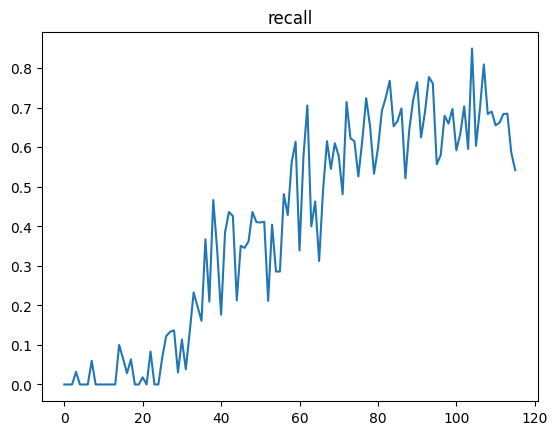

In [ ]:
plt.plot(rec)
plt.title('recall')
plt.yticks(np.arange(0, 0.9, 0.1))
plt.show()

In [ ]:
np.savetxt('/content/drive/MyDrive/model_state/recall_52M_attempt_best', rec)

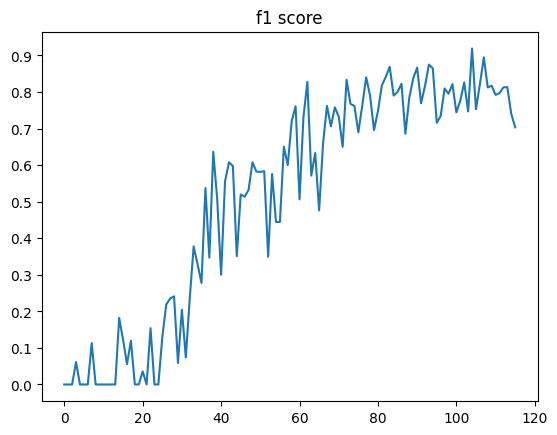

In [ ]:
plt.plot(f_1)
plt.title('f1 score')
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

In [ ]:
np.savetxt('/content/drive/MyDrive/model_state/f1_52M_attempt_best', f_1)

Text(0.5, 1.0, 'loss function')

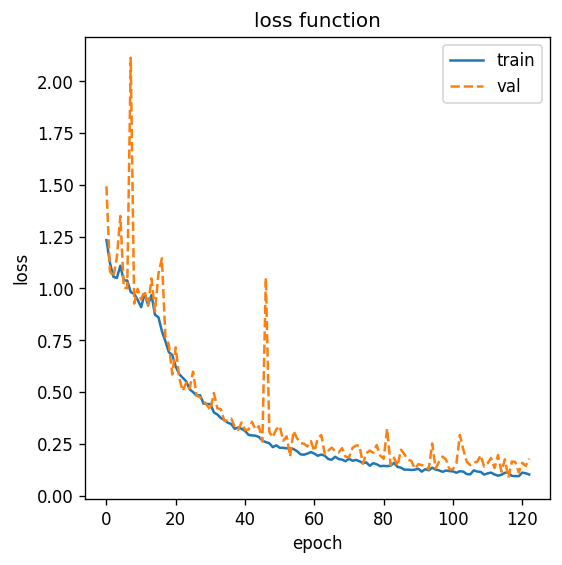

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5), dpi=120)
ax.plot(tr_epochs_loss[2:], label='train')
ax.plot(val_epochs_loss[2:], label='val', linestyle='dashed')
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('loss function')

In [ ]:
np.savetxt('/content/drive/MyDrive/model_state/train_loss_attempt', tr_epochs_loss)
np.savetxt('/content/drive/MyDrive/model_state/val_loss_attempt', val_epochs_loss)

In [ ]:
f = [a for a in test]

Pred/true boxes: 11/7
Crop from sep0119_000056.fits


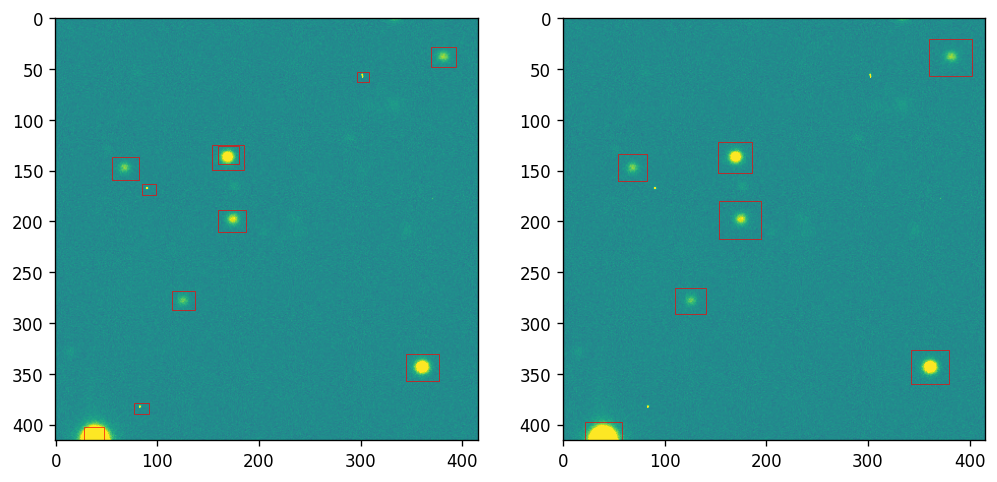

Pred/true boxes: 4/1
Crop from jun0915_000032.fits


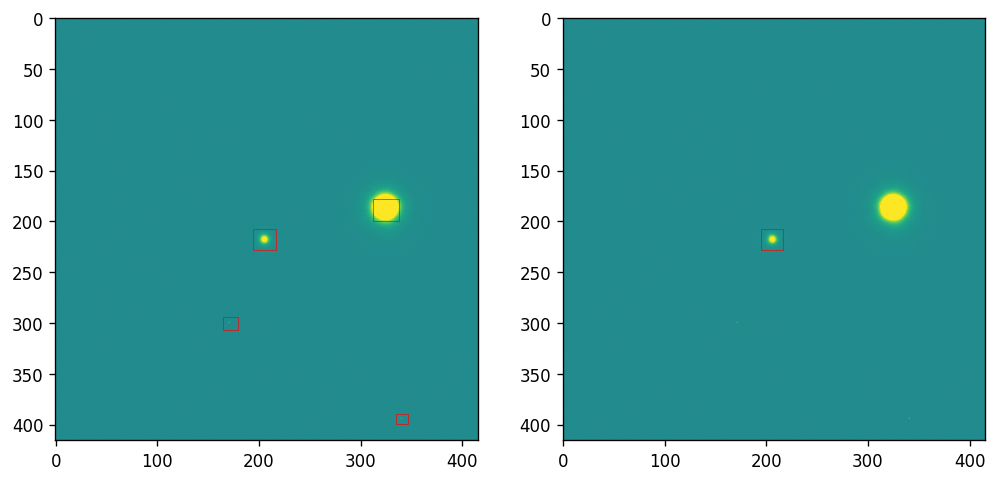

Pred/true boxes: 10/1
Crop from oct0218_000135.fits


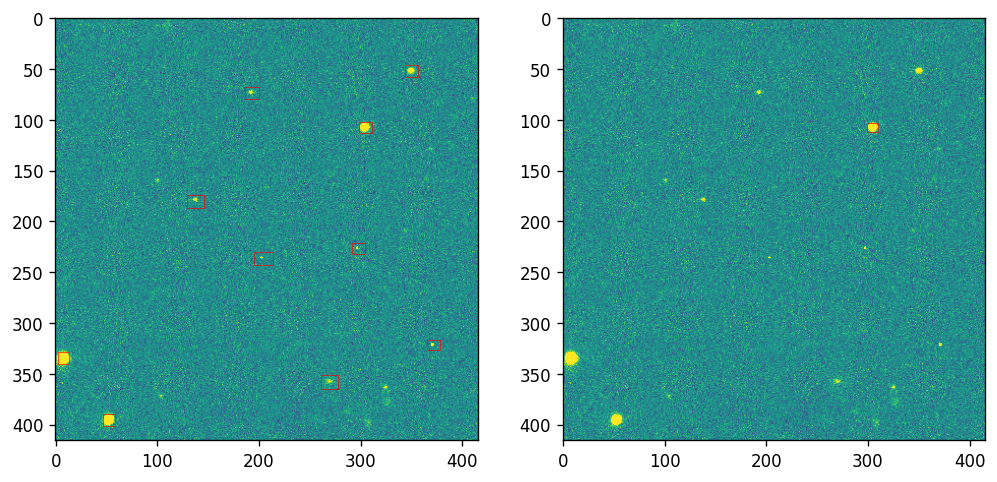

Pred/true boxes: 7/2
Crop from may1418_000006.fits


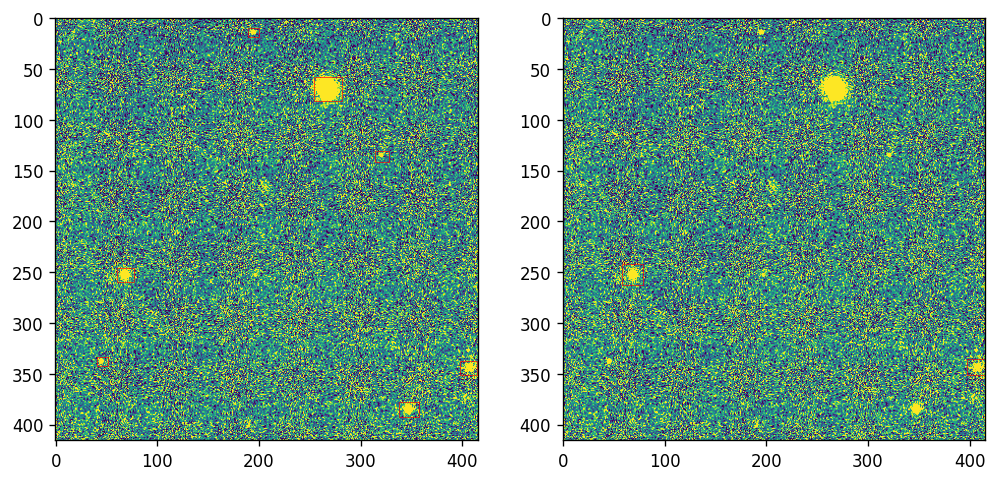

In [ ]:
couple_exmpls([f[0]], 0.5,  0.45, anchors)

# Eval

In [ ]:
scaled_anchors = (torch.tensor(anchors) 
    * torch.tensor(S))[0, :, :]
scaled_anchors = scaled_anchors.to(device)

In [ ]:
pred_b, true_b = get_val_boxes(f, model, scaled_anchors, anchors, 0.45,  0.5, device = device)

In [ ]:
for i in range(len(pred_b)):
  pred_b[i][3] = pred_b[i][3] - 1/416
  pred_b[i][4] = pred_b[i][4] - 1/416

In [ ]:
metcs = []
for _ in range(10):
  f = [a for a in test]
  pred_b, true_b = get_val_boxes(f, model, scaled_anchors, anchors, 0.45,  0.5, device = device)
  for i in range(len(pred_b)):
    pred_b[i][3] = pred_b[i][3] - 1/416
    pred_b[i][4] = pred_b[i][4] - 1/416
  met = metrics(pred_b, true_b, iou_threshold=0.5)
  metcs.append(met)

In [ ]:
mean_score = np.mean(metcs, axis=0)

In [ ]:
met = metrics(pred_b, true_b, iou_threshold=0.5)

In [ ]:
print(f'Recall: {round(mean_score[0], 2)}\nF1: {round(mean_score[1], 2)}\nCenter_x: {round(mean_score[2], 2)}\nCenter_y: {round(mean_score[3], 2)}\nfwhm_x: {round(mean_score[4], 2)}\nfwhm_y: {round(mean_score[5], 2)}')

Recall: 0.78
F1: 0.87
Center_x: 0.49
Center_y: 0.36
fwhm_x: 2.58
fwhm_y: 2.16


# Test

In [ ]:
image = imread(os.path.join('unique_Fields', 'jun0915_000032.fits'), plugin='fits').astype('float32')

In [226]:
class FullImagePrediction:
  def __init__(self, image_path, stats):

    self.image_path = image_path
    self.stats = stats

  def preparation_image(self):
    image = imread(self.image_path, plugin='fits').astype('float32')
    new_image_wh = 4160
    old_image_wh = 4096
    res = np.full((new_image_wh, new_image_wh), 0, dtype='float32')
    x_center = (new_image_wh - old_image_wh) // 2
    y_center = (new_image_wh - old_image_wh) // 2
    res[y_center:y_center+old_image_wh, x_center:x_center+old_image_wh] = image
    return res

  def prediction_chunks_image(self):
    import time
    from torchvision import transforms

    img_transforms = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(self.stats['mean'], self.stats['std'])])
    res = self.preparation_image()
    all_boxes = []
    x = 0
    y = 0
    start = time.time()
    while x != res.shape[1]:
        chunk_im = res[x:x+416,y:y+416]
        normalized_image = img_transforms(chunk_im)
        pred_norm = get_bias_prediction(normalized_image[None, ...], 0.5, 0.45, anchors, transform=True, x_bias=x, y_bias=y)
        all_boxes += pred_norm
        x +=416
        if x == res.shape[1]:
          x = 0
          y += 416
        if y == res.shape[0]:
          break
    end = time.time() - start
    print(f'Time full image prediction: {end}\n Total objects: {len(all_boxes)}')
    return all_boxes, res

  def filtering_boxes_img(self, upper_bound=4000, lower_bound=160):
    assert upper_bound <= 4096
    preds_boxes, img = self.prediction_chunks_image()
    filt_img = img[lower_bound:upper_bound, lower_bound:upper_bound]
    del img
    filt_bxs = []
    for b in preds_boxes:
      if (b[2]  - b[4] / 2 ) < lower_bound / 416 or (b[3]  - b[5] / 2) < lower_bound/416 or \
        (b[2]  + b[4] / 2 ) > upper_bound/416 or ((b[3]  + b[5] / 2)) > upper_bound/416:
        continue
      b[2] = b[2] - lower_bound / 416
      b[3] = b[3] - lower_bound / 416
      filt_bxs.append(b)
    return filt_bxs, filt_img

  def plot_pred_image(self):
    fig, ax = plt.subplots(1, figsize=(10,10), dpi=90)
    bxs, imgg = self.filtering_boxes_img()
    print(f'Num of objects after filtering: {len(bxs)}')
    im_s = 416
    ax.imshow(imgg, cmap='viridis', vmin = imgg.mean() - imgg.std(), vmax = imgg.mean() + imgg.std()
            )
    
    for box in bxs:
      assert len(box) == 6
      class_pred = box[0]
      box = box[2:]
      upper_left_x = box[0]  - box[2] / 2
      upper_left_y = box[1]  - box[3] / 2
      rect_pred = patches.Rectangle(
          (upper_left_x * im_s, upper_left_y * im_s),
          box[2] * im_s,
          box[3] * im_s,
          linewidth=0.4,
          edgecolor='r',
          facecolor="none",
      )
      
      ax.add_patch(rect_pred)
    plt.show()

In [227]:
im_path = os.path.join('unique_Fields', 'jun0915_000032.fits')

In [ ]:
im_path = os.path.join('unique_Fields', 'sep0119_000056.fits')

In [ ]:
im_path = os.path.join('unique_Fields', 'oct0218_000135.fits')

In [ ]:
im_path = os.path.join('unique_Fields','aug2615_000018.fits')

In [223]:
im_path = os.path.join('unique_Fields','apr2118_000074.fits')

In [228]:
pred_cl = FullImagePrediction(im_path, stats)

Time full image prediction: 51.977341175079346
 Total objects: 1552


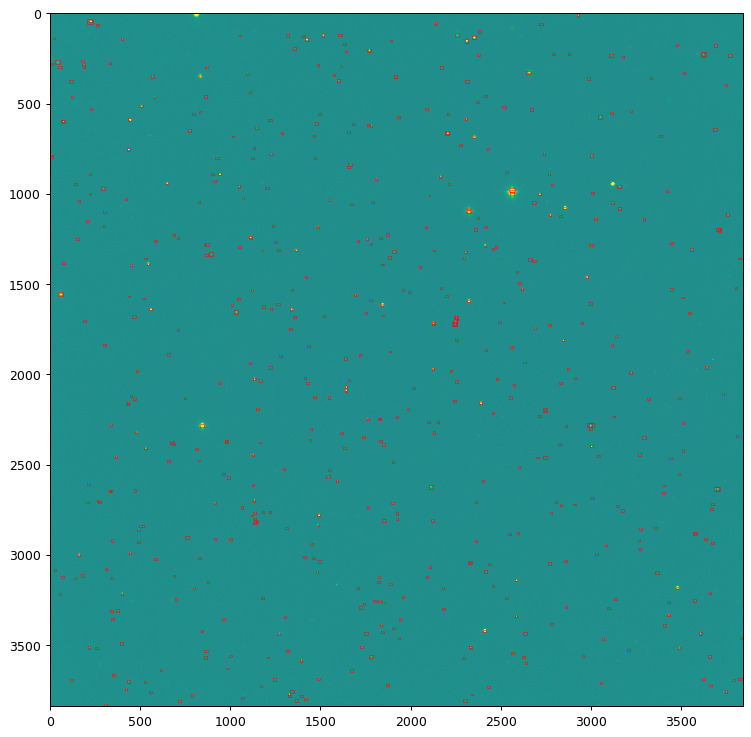

In [225]:
pred_cl.plot_pred_image()

Time full image prediction: 54.940293312072754
 Total objects: 1594


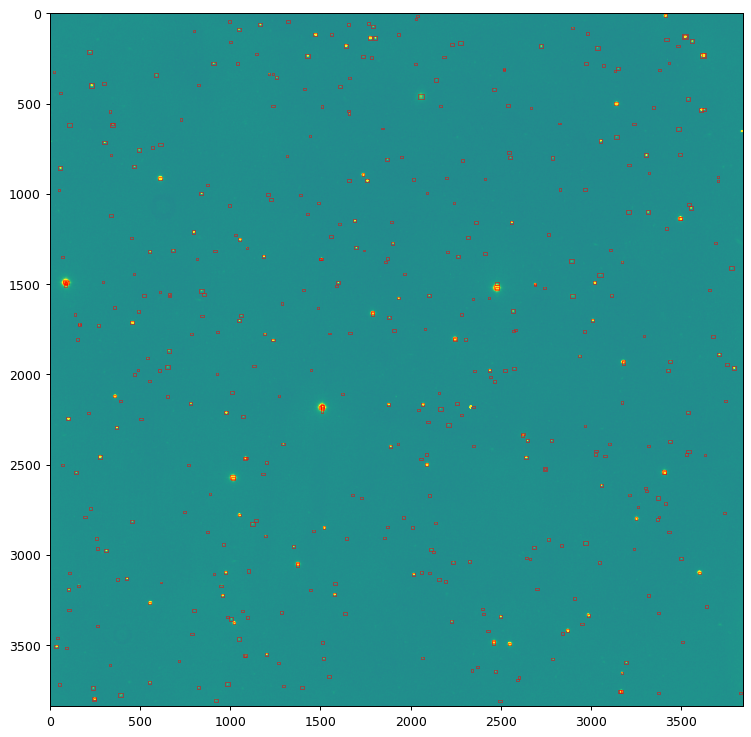

In [ ]:
pred_cl.plot_pred_image()

Time full image prediction: 57.33673620223999
 Total objects: 1768


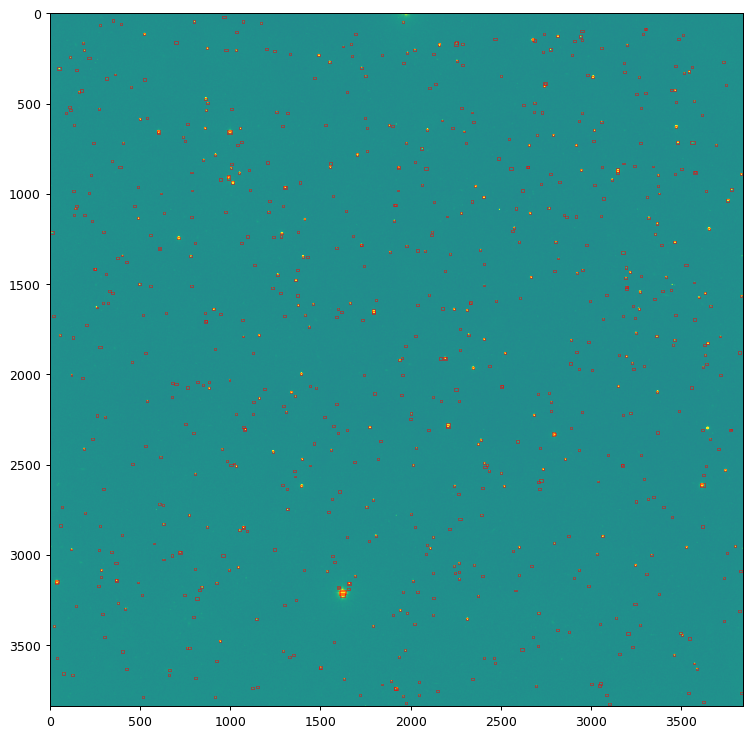

In [ ]:
pred_cl.plot_pred_image()

Time full image prediction: 59.8205201625824
 Total objects: 1805


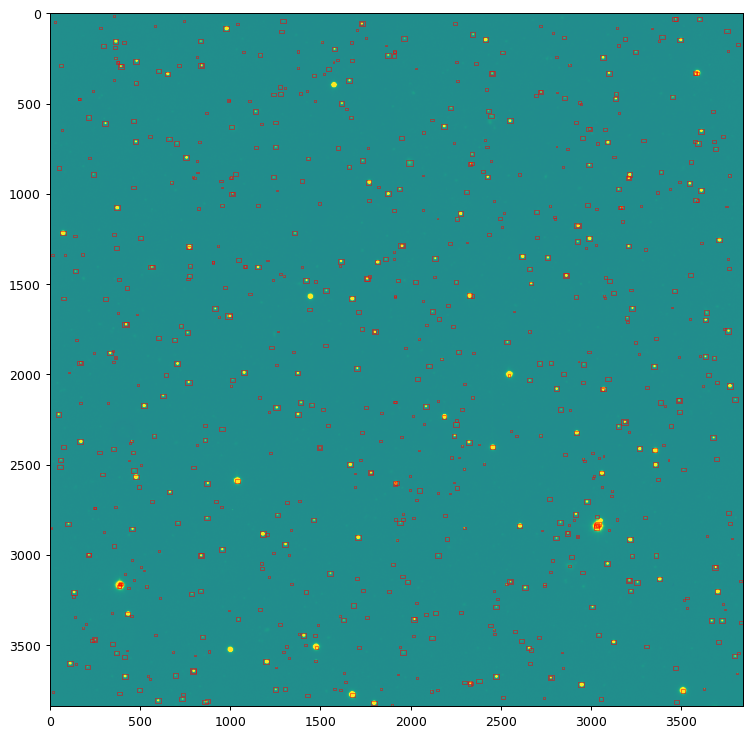

In [ ]:
pred_cl.plot_pred_image()

Time full image prediction: 46.16589593887329
 Total objects: 1045


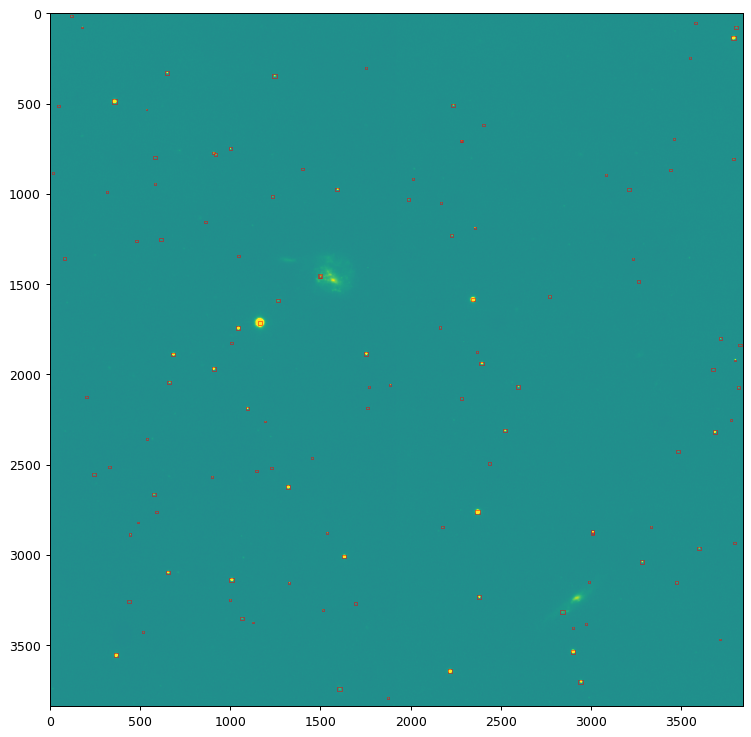

In [ ]:
pred_cl.plot_pred_image()

5 Изображений 4kX4k  
Среднее количество объектов: ~1500 тыс.  
Среднее время выполенния: ~54 с.

# Comparison

Time full image prediction: 56.23213601112366
 Total objects: 1045
Num of objects after filtering: 121


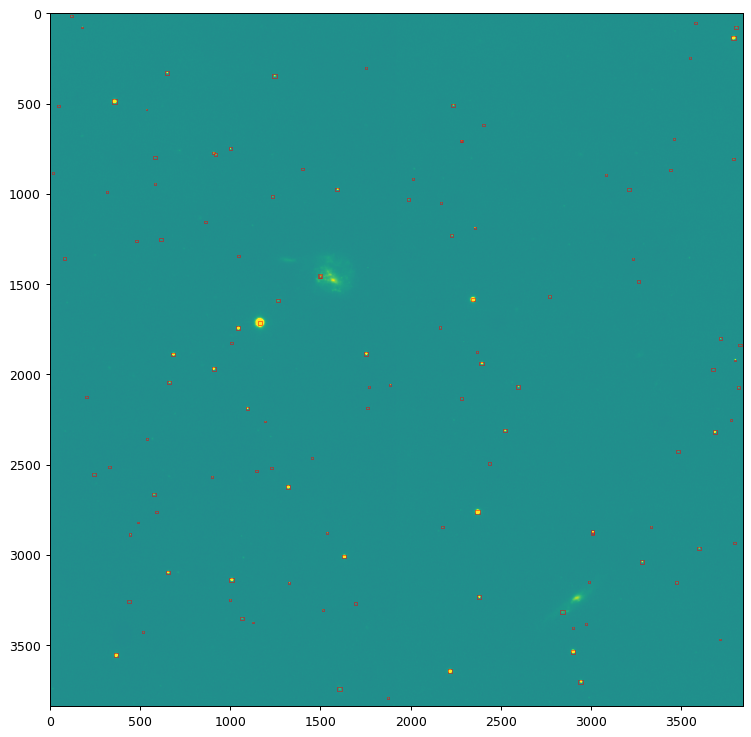

In [229]:
pred_cl.plot_pred_image()

In [156]:
with open("annot_3_30.json") as f:
  annotations = np.array(json.load(f))

In [157]:
for a in annotations:
  if a['filename'] == 'jun0915_000032.fits':
    an = a
    break

In [230]:
image = imread(os.path.join('unique_Fields', 'jun0915_000032.fits'), plugin='fits').astype('float32')

Num of gt: 75


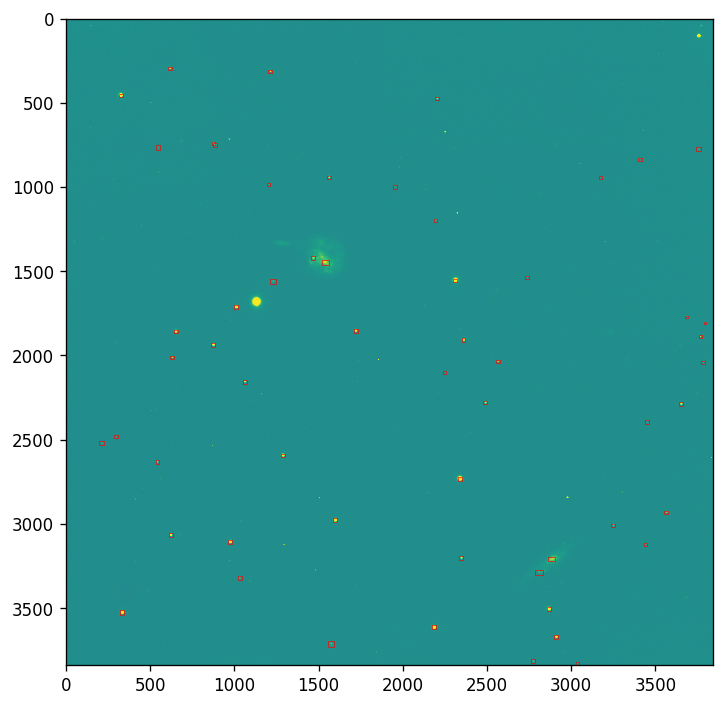

In [235]:
fig, ax = plt.subplots(1, figsize=(7,7), dpi=120)
ax.imshow(image[160:4000, 160:4000], cmap='viridis', vmin = image.mean() - image.std(), vmax = image.mean() + image.std()
         )
print(f'Num of gt: {len(an["bboxes"])}')
for p in an['bboxes']:
    x_min = p[0] - 160
    y_min = p[1] - 160
    x_max = p[2] - 160
    y_max = p[3] - 160
    if x_min < 160 or y_min < 160 or x_max > 4000 or y_max > 4000:
      continue
    rect =  patches.Rectangle((x_min, y_min),(x_max - x_min),(y_max - y_min), linewidth=0.4, edgecolor='r', facecolor='none',)
    ax.add_patch(rect)